https://www.kaggle.com/competitions/reconocimiento-de-expresiones-faciales

In [10]:
import numpy as np
import pandas as pd
import os
import cv2
from skimage.io import imread
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras 
from tensorflow.keras import layers, models
from tqdm import tqdm
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import glob 
import warnings
warnings.filterwarnings('ignore')


### READ DATA 

In [2]:
data_path = './data/train'
pd.DataFrame(os.listdir(data_path),columns=['File_Name'])

,File_Name
0,angry
1,disgust
2,fear
3,happy
4,neutral
5,sad
6,surprise


In [3]:
files = [i for i in glob.glob(data_path + "//*//*")]
np.random.shuffle(files)
labels = [os.path.dirname(i).split("\\")[-1] for i in files]
data = zip(files, labels)
dataframe = pd.DataFrame(data, columns = ["Image", "Label"])
dataframe

,Image,Label
0,./data/train\happy\11007.jpg,happy
1,./data/train\happy\34864.jpg,happy
2,./data/train\sad\23154.jpg,sad
3,./data/train\happy\13504.jpg,happy
4,./data/train\surprise\4850.jpg,surprise
...,...,...
28816,./data/train\neutral\15091.jpg,neutral
28817,./data/train\surprise\21600.jpg,surprise
28818,./data/train\sad\32801.jpg,sad
28819,./data/train\neutral\6554.jpg,neutral


### VISUALIZATION

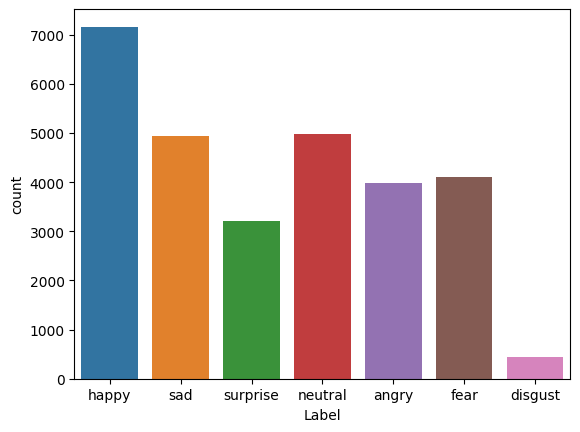

In [4]:
import matplotlib.pyplot as plotter

sns.countplot(x = dataframe["Label"], hue=dataframe["Label"])
plotter.xticks(rotation = 0);

### PREPROCESSING

In [43]:
# Hiperparametros:

batch_size = 64
target_size = (64,64)
validation_split = 0.2

In [44]:
train= tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=validation_split,
    subset="training",
    seed=100,
    image_size=target_size,
    batch_size=batch_size,
)

validation= tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=validation_split,
    subset="validation",
    seed=200,
    image_size=target_size,
    batch_size=batch_size,
)

Found 28821 files belonging to 7 classes.
Using 23057 files for training.
Found 28821 files belonging to 7 classes.
Using 5764 files for validation.


In [45]:
train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [46]:
train_size = len(train)
val_size = len(validation)
total = train_size + val_size

print(f'train samples count:\t\t{train_size}\t({(100 * train_size/total):.2f}%)')
print(f'validation samples count:\t{val_size}\t({(100 * val_size/total):.2f}%)')
print('================================================')
print(f'Total:\t\t\t\t{total}\t({(100 * total/total):.2f}%)')

train samples count:		361	(79.87%)
validation samples count:	91	(20.13%)
Total:				452	(100.00%)


In [47]:
class_names=train.class_names
class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

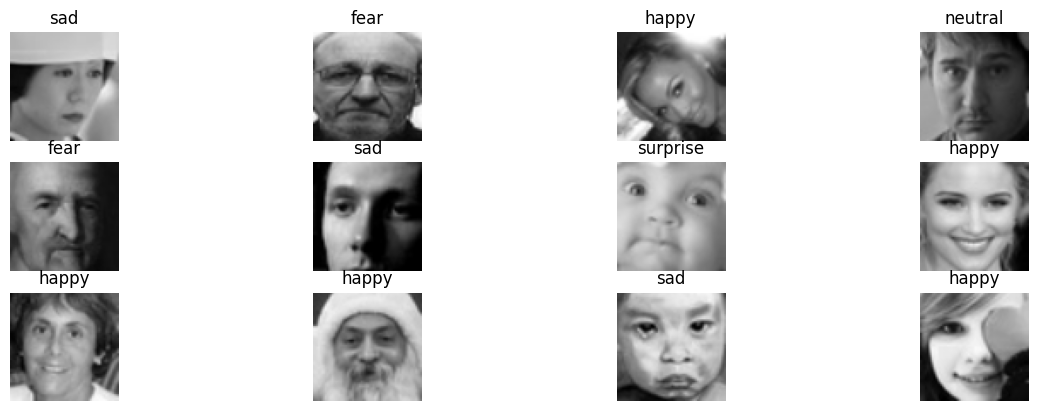

In [48]:
plt.figure(figsize=(15, 20))
for images, labels in train.take(1):
    for i in range(12):
        ax = plt.subplot(12, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### MODELING

In [49]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (batch_size, batch_size, 3), 
                    include_top = False, 
                    weights = 'imagenet')

base_model.trainable = False

In [50]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(7, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,767,367 (60.15 MB)

 Trainable params: 1,052,679 (4.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [51]:
checkpoint =ModelCheckpoint("model_TCKFaces.keras", save_best_only=True)
early_stopping =EarlyStopping(patience=5, restore_best_weights=True)
model.compile(optimizer ='Adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [52]:
history = model.fit(train,epochs=40,validation_data=validation,callbacks=[checkpoint,early_stopping])

Epoch 1/40
361/361 ━━━━━━━━━━━━━━━━━━━━ 437s 1s/step - accuracy: 0.2699 - loss: 7.5768 - val_accuracy: 0.4061 - val_loss: 1.6083
Epoch 2/40
361/361 ━━━━━━━━━━━━━━━━━━━━ 418s 1s/step - accuracy: 0.3576 - loss: 1.6814 - val_accuracy: 0.4330 - val_loss: 1.5200
Epoch 3/40
361/361 ━━━━━━━━━━━━━━━━━━━━ 409s 1s/step - accuracy: 0.3822 - loss: 1.5999 - val_accuracy: 0.4591 - val_loss: 1.4421
Epoch 4/40
361/361 ━━━━━━━━━━━━━━━━━━━━ 412s 1s/step - accuracy: 0.4081 - loss: 1.5549 - val_accuracy: 0.4686 - val_loss: 1.4243
Epoch 5/40
361/361 ━━━━━━━━━━━━━━━━━━━━ 415s 1s/step - accuracy: 0.4188 - loss: 1.5220 - val_accuracy: 0.4971 - val_loss: 1.3340
Epoch 6/40
361/361 ━━━━━━━━━━━━━━━━━━━━ 410s 1s/step - accuracy: 0.4340 - loss: 1.4687 - val_accuracy: 0.5075 - val_loss: 1.3130
Epoch 7/40
361/361 ━━━━━━━━━━━━━━━━━━━━ 417s 1s/step - accuracy: 0.4477 - loss: 1.4377 - val_accuracy: 0.5163 - val_loss: 1.2901
Epoch 8/40
361/361 ━━━━━━━━━━━━━━━━━━━━ 408s 1s/step - accuracy: 0.4533 - loss: 1.4181 - val_accu

In [53]:
hist=pd.DataFrame(history.history)
hist

,accuracy,loss,val_accuracy,val_loss
0,0.293360,3.519131,0.406142,1.608265
1,0.358893,1.675077,0.433033,1.519956
2,0.386997,1.591708,0.459056,1.442079
3,0.406948,1.550397,0.468598,1.424293
4,0.423169,1.512815,0.497051,1.333991
5,0.434228,1.469545,0.507460,1.312957
6,0.447586,1.441392,0.516308,1.290115
7,0.456174,1.405457,0.521166,1.259223
8,0.465715,1.391665,0.537821,1.238386
9,0.471007,1.376854,0.549792,1.213607


### Visualization of model

In [54]:
def evaluate_model(model, data):
    test_loss, test_accuracy = model.evaluate(data, steps=len(data))
    print(f"Loss validate dataset: { test_loss }")
    print(f"Accuracy validate dataset: { test_accuracy }")

In [55]:
evaluate_model(model, validation)

91/91 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.6770 - loss: 0.9272
Loss validate dataset: 0.9421473145484924
Accuracy validate dataset: 0.6693268418312073


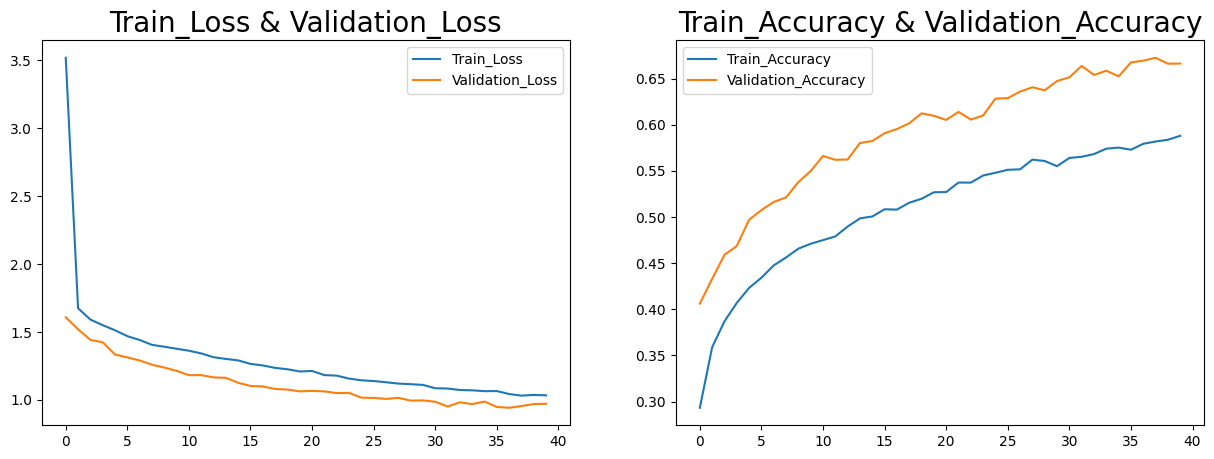

In [56]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist['loss'],label='Train_Loss')
plt.plot(hist['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist['accuracy'],label='Train_Accuracy')
plt.plot(hist['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

# Real Test

In [57]:
test_path = './data/test'

In [58]:
test= tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=target_size,
    batch_size=batch_size,
    shuffle=False
)

Found 7066 files belonging to 1 classes.


In [59]:
pred = model.predict(test)

111/111 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step


In [60]:
predicted_classes = np.argmax(pred, axis=1)

In [61]:
class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [62]:
dict_emotions = {
    0:'angry',
    1:'disgust',
    2:'fear',
    3:'happy',
    4:'neutral',
    5:'sad',
    6:'surprise'
}

In [63]:
pred_class_mapped = np.array([dict_emotions[num] for num in predicted_classes])

In [64]:
list_id = []
for file in os.listdir('./data/test/all'):
    id = file.split('.')[0]
    list_id.append(id)

In [65]:
df_pred = pd.DataFrame(list_id, columns = ["id_img"])
df_pred['label'] = pred_class_mapped

In [66]:
submission = df_pred

In [67]:
sample = pd.read_csv('sample_submision.csv')

In [68]:
def chequeator(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.index.all() == sample.index.all():
                print("You're ready to submit!")
                submission.to_csv("submission.csv", index = False) #muy importante el index = False
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("")


In [69]:
chequeator(submission)

You're ready to submit!
